# 매출액 예측 모델
- autogluon을 활용한 회귀분석
- 2023년 1월 ~ 2024년 1월 경기도 카드 소비 데이터, 유동인구 데이터, 상권 지표 데이터 활용
- os: window 64
- tool: jupyter lab

## 데이터 불러오기

In [105]:
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.tabular
import sklearn
import dask.dataframe as dd
import vaex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.preprocessing import OneHotEncoder
import shap
import matplotlib.font_manager as fm
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# 개발 환경 확인
print("autogluon.tabular version:", autogluon.tabular.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)

autogluon.tabular version: 1.1.1
pandas version: 2.0.0
numpy version: 1.24.4
scikit-learn version: 1.3.0


In [41]:
card_data = '../data/five_city_data/merged_gyeonggi_day.csv'
flowpop_data = '../data/five_city_data/flowpop.csv'
commercial_area_ndc_data = '../data/five_city_data/updated_commerical_area_ndc.csv'
card_sample = '../data/gm_card.csv'

In [43]:
# 데이터 불러오기, 대용량 데이터를 불러오기 위한 dask 라이브러리 활용
card_df = dd.read_csv(card_data,encoding='utf-8')
flowpop_df = dd.read_csv(flowpop_data,encoding='utf-8')
comm_df = dd.read_csv(commercial_area_ndc_data,encoding='utf-8')

## 데이터 전처리

#### 카드 소비 데이터

In [44]:
card_df.head()

,ta_ymd,cty_rgn_no,admi_cty_no,card_tpbuz_cd,card_tpbuz_nm_1,card_tpbuz_nm_2,hour,sex,age,day,amt,cnt
0,20230101,41210,41210510,D05,소매/유통,선물/완구,3,M,5,7,57576,2
1,20230101,41210,41210510,D11,소매/유통,종합소매점,3,F,7,7,8523,2
2,20230101,41210,41210510,D11,소매/유통,종합소매점,7,F,7,7,8023,2
3,20230101,41210,41210510,F02,생활서비스,미용서비스,3,M,4,7,28532,2
4,20230101,41210,41210510,F02,생활서비스,미용서비스,4,F,7,7,74074,2


#### 유동인구 데이터

In [45]:
flowpop_df.head()

,ETL_M,ADMI_CD,TIME_CD,M_10_CNT,F_10_CNT,M_20_CNT,F_20_CNT,M_30_CNT,F_30_CNT,M_40_CNT,F_40_CNT,M_50_CNT,F_50_CNT,M_60_CNT,F_60_CNT,M_70_CNT,F_70_CNT
0,2023-01,41111560,0,2858.84,2353.63,6248.39,4939.41,6684.28,4267.07,6304.54,5347.71,7495.55,5583.58,5411.89,4223.19,1086.22,1165.65
1,2023-01,41111560,1,3491.05,3021.34,7622.91,6183.19,7793.08,5365.17,7591.39,6765.04,9010.54,6842.45,6755.23,5363.00,1369.42,1499.24
2,2023-01,41111560,2,3433.43,3094.93,7369.46,5974.40,7510.31,5217.52,7282.29,6413.82,8717.53,6483.81,6631.32,5241.16,1303.01,1483.83
3,2023-01,41111560,3,3194.88,2955.40,7014.45,5704.24,7172.49,5138.34,6906.87,6334.15,8650.77,6395.10,6540.17,5316.28,1333.23,1501.99
4,2023-01,41111560,4,3003.63,2818.85,6716.24,5370.39,6980.61,4920.87,6908.53,6217.82,8911.40,6465.25,6940.02,5642.58,1519.33,1577.52


#### 상권지표 데이터

In [46]:
comm_df.head()

,행정동코드,기준분기,운영점포평균영업기간,폐업점포평균영업기간,상권변동지표구분,상권변동지표구분명
0,41111560,1,99.9,46.4,HL,상권축소
1,41111566,1,83.5,43.2,LL,다이나믹
2,41111571,1,97.9,38.1,HL,상권축소
3,41111572,1,92.9,58.5,HH,정체
4,41111573,1,93.1,70.1,HH,정체


### 월 별 데이터로 통합, 유동인구와 상권변화지표도 통합

In [47]:
# 해당일, 해당동의 해당 업종의 특정시간에 매출과 매출건수 총액
card_df2 = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum", "cnt":"sum"}).reset_index()

In [48]:
card_df2.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt,cnt
0,20230101,41210510,D05,57576,2
1,20230101,41210510,D11,16546,4
2,20230101,41210510,F02,313388,16
3,20230101,41210510,Q01,69266,1
4,20230101,41210510,Q15,78222,6


In [49]:
#월 별 계산을 위해 데이터 변환
card_df2['ta_ymd'] = card_df2['ta_ymd'].astype(str) 

In [50]:
card_df2['ta_ymd'] = card_df2['ta_ymd'].str.slice(0, 6)

In [51]:
card_df2.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt,cnt
0,202301,41210510,D05,57576,2
1,202301,41210510,D11,16546,4
2,202301,41210510,F02,313388,16
3,202301,41210510,Q01,69266,1
4,202301,41210510,Q15,78222,6


In [52]:
# 월별 행정구별, 업종별, amt 및 cnt 평균
grouped_df = card_df2.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum", "cnt": "sum"}).reset_index()
grouped_df.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt,cnt
0,202301,41210510,D05,633562,28
1,202301,41210510,D11,171040,28
2,202301,41210510,F02,12060758,375
3,202301,41210510,Q01,1818710,9
4,202301,41210510,Q15,2167723,87


In [53]:
# join을 위한 데이터 통일
flowpop_df['ETL_M'] = flowpop_df['ETL_M'].str.replace('-', '')
# 총 유동인구 계산
cnt_columns = flowpop_df.loc[:, 'M_10_CNT':'F_70_CNT'].columns
flowpop_df['TOTAL_POPULATION'] = flowpop_df[cnt_columns].sum(axis=1)
# 해당 월에 해당 동에 해당 시간에 방문한 유동인구수 평균
flowpop_df_temp = flowpop_df.groupby(["ETL_M", "ADMI_CD","TIME_CD"]).agg({"TOTAL_POPULATION": "mean"}).reset_index()
# 해당 월에 해당 동에 방문한 유동인구 평균 총합
flow_g_df = flowpop_df_temp.groupby(["ETL_M", "ADMI_CD"]).agg({"TOTAL_POPULATION": "sum"}).reset_index()

In [54]:
flow_g_df.head()

,ETL_M,ADMI_CD,TOTAL_POPULATION
0,202301,41111560,2968697.82
1,202301,41111566,5438074.73
2,202301,41111571,2764829.73
3,202301,41111572,3664691.19
4,202301,41111573,5278122.27


In [55]:
# 데이터 결합
merged_df = dd.merge(grouped_df, flow_g_df, how='inner', left_on=['ta_ymd', 'admi_cty_no'], right_on=['ETL_M', 'ADMI_CD'])


In [56]:
merged_df.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt,cnt,ETL_M,ADMI_CD,TOTAL_POPULATION
0,202301,41210510,D05,633562,28,202301,41210510,13850.98
1,202301,41210510,D11,171040,28,202301,41210510,13850.98
2,202301,41210510,F02,12060758,375,202301,41210510,13850.98
3,202301,41210510,Q01,1818710,9,202301,41210510,13850.98
4,202301,41210510,Q15,2167723,87,202301,41210510,13850.98


In [57]:
# 기준분기 생성 함수
def get_quarter(month):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4

# merged_df에서 기준분기 생성
merged_df['year'] = merged_df['ta_ymd'].astype(str).str[:4].astype(int)
merged_df['month'] = merged_df['ta_ymd'].astype(str).str[4:6].astype(int)
merged_df['기준분기'] = merged_df['month'].apply(get_quarter)

# comm_df에서 기준분기와 매칭될 수 있도록 연도를 추가
comm_df['year'] = 2023


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('month', 'int64'))



In [58]:
merged_df.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt,cnt,ETL_M,ADMI_CD,TOTAL_POPULATION,year,month,기준분기
0,202301,41210510,D05,633562,28,202301,41210510,13850.98,2023,1,1
1,202301,41210510,D11,171040,28,202301,41210510,13850.98,2023,1,1
2,202301,41210510,F02,12060758,375,202301,41210510,13850.98,2023,1,1
3,202301,41210510,Q01,1818710,9,202301,41210510,13850.98,2023,1,1
4,202301,41210510,Q15,2167723,87,202301,41210510,13850.98,2023,1,1


In [59]:
comm_df.head()

,행정동코드,기준분기,운영점포평균영업기간,폐업점포평균영업기간,상권변동지표구분,상권변동지표구분명,year
0,41111560,1,99.9,46.4,HL,상권축소,2023
1,41111566,1,83.5,43.2,LL,다이나믹,2023
2,41111571,1,97.9,38.1,HL,상권축소,2023
3,41111572,1,92.9,58.5,HH,정체,2023
4,41111573,1,93.1,70.1,HH,정체,2023


In [60]:
# comm_df와 merged_df 병합
merged_result = dd.merge(merged_df, comm_df, left_on=['admi_cty_no', '기준분기', 'year'], right_on=['행정동코드', '기준분기', 'year'], how='left')

# 병합 결과에서 필요없는 열 제거 (예: '행정동코드')
merged_result = merged_result.drop(columns=['행정동코드'])

# 병합 결과 출력
merged_result.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt,cnt,ETL_M,ADMI_CD,TOTAL_POPULATION,year,month,기준분기,운영점포평균영업기간,폐업점포평균영업기간,상권변동지표구분,상권변동지표구분명
0,202301,41210510,D05,633562,28,202301,41210510,13850.98,2023,1,1,188.5,358.0,HH,정체
1,202301,41210510,D11,171040,28,202301,41210510,13850.98,2023,1,1,188.5,358.0,HH,정체
2,202301,41210510,F02,12060758,375,202301,41210510,13850.98,2023,1,1,188.5,358.0,HH,정체
3,202301,41210510,Q01,1818710,9,202301,41210510,13850.98,2023,1,1,188.5,358.0,HH,정체
4,202301,41210510,Q15,2167723,87,202301,41210510,13850.98,2023,1,1,188.5,358.0,HH,정체


### 필요없는 속성 제거

In [62]:
merged_result.columns

Index(['ta_ymd', 'admi_cty_no', 'card_tpbuz_cd', 'amt', 'cnt', 'ETL_M',
       'ADMI_CD', 'TOTAL_POPULATION', 'year', 'month', '기준분기', '운영점포평균영업기간',
       '폐업점포평균영업기간', '상권변동지표구분', '상권변동지표구분명'],
      dtype='object')

In [72]:
# 필요없는 속성 제거
columns_to_drop = ['ta_ymd','ETL_M', 'ADMI_CD', 'year','기준분기',
                   '상권변동지표구분명','month']
merged_df2 = merged_result.drop(columns=columns_to_drop)

In [29]:
# 505027 rows
len(merged_df2)

134360

In [66]:
merged_df2.head()

,admi_cty_no,card_tpbuz_cd,amt,cnt,TOTAL_POPULATION,운영점포평균영업기간,폐업점포평균영업기간,상권변동지표구분
0,41210510,D05,633562,28,13850.98,188.5,358.0,HH
1,41210510,D11,171040,28,13850.98,188.5,358.0,HH
2,41210510,F02,12060758,375,13850.98,188.5,358.0,HH
3,41210510,Q01,1818710,9,13850.98,188.5,358.0,HH
4,41210510,Q15,2167723,87,13850.98,188.5,358.0,HH


## train-test split

In [74]:
# dask 타입의 dataframe을 pandas로 변경
merged_df2 = merged_df2.compute()

In [80]:
# 학습을 위해 dataset 타입 변경
merged_df2 = TabularDataset(merged_df2)

In [81]:
merged_df2.head()

,admi_cty_no,card_tpbuz_cd,amt,cnt,TOTAL_POPULATION,운영점포평균영업기간,폐업점포평균영업기간,상권변동지표구분
0,41210510,D05,633562,28,13850.98,188.5,358.0,HH
1,41210510,D11,171040,28,13850.98,188.5,358.0,HH
2,41210510,F02,12060758,375,13850.98,188.5,358.0,HH
3,41210510,Q01,1818710,9,13850.98,188.5,358.0,HH
4,41210510,Q15,2167723,87,13850.98,188.5,358.0,HH


In [82]:
# 현재 없는 2024년 1분기 데이터 삭제 
merged_df2 = merged_df2.dropna(subset=['상권변동지표구분'])

In [83]:
len(merged_df2)

75354

In [84]:
# 8:2로 train, test 데이터 분리 
train_df, test_df = train_test_split(merged_df2, test_size=0.2, random_state=42)

## 모델 학습

In [85]:
# Autogluon TabularPredictor 사용
predictor = TabularPredictor(
    label='amt',  # 예측할 타겟 컬럼 설정
    eval_metric='mean_absolute_error'  # 평가 지표 설정: MAE
)

# 모델 훈련
predictor.fit(
    train_data=train_df, 
    presets='good_quality_faster_inference_only_refit',  # 가벼운 모델 설정
    time_limit=3600  # 학습 시간 2시간으로 제한 (3600초)
)

# 예측 수행
predictions = predictor.predict(test_df)

# 예측 결과 및 실제 값 비교
print("Predictions:\n", predictions)
print("Actual:\n", test_df['amt'])

No path specified. Models will be saved in: "AutogluonModels\ag-20240718_004914"
Preset alias specified: 'good_quality_faster_inference_only_refit' maps to 'good_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       16.39 GB / 31.69 GB (51.7%)
Disk Space Avail:   517.19 GB / 930.86 GB (55.6%)
Presets specified: ['good_quality_faster_inference_only_refit']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data

(_ray_fit pid=30948) [1000]	valid_set's l1: 1.77673e+08
(_ray_fit pid=31020) [3000]	valid_set's l1: 1.64323e+08 [repeated 10x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=31020) [5000]	valid_set's l1: 1.48488e+08 [repeated 10x across cluster]
(_ray_fit pid=22288) [7000]	valid_set's l1: 1.2353e+08 [repeated 10x across cluster]
(_ray_fit pid=31020) [9000]	valid_set's l1: 1.32299e+08 [repeated 10x across cluster]


(_dystack pid=19824) 	-148327996.0663	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	35.66s	 = Training   runtime
(_dystack pid=19824) 	114.95s	 = Validation runtime
(_dystack pid=19824) Fitting model: LightGBM_BAG_L1 ... Training model for up to 525.05s of the 820.2s of remaining time.
(_dystack pid=19824) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.12%)


(_ray_fit pid=12876) [1000]	valid_set's l1: 1.03295e+08 [repeated 10x across cluster]
(_ray_fit pid=2136) [3000]	valid_set's l1: 8.86413e+07 [repeated 16x across cluster]
(_ray_fit pid=2136) [5000]	valid_set's l1: 8.42949e+07 [repeated 16x across cluster]
(_ray_fit pid=12876) [7000]	valid_set's l1: 8.68051e+07 [repeated 16x across cluster]
(_ray_fit pid=12876) [9000]	valid_set's l1: 8.54069e+07 [repeated 16x across cluster]


(_dystack pid=19824) 	-89029170.0451	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	41.48s	 = Training   runtime
(_dystack pid=19824) 	206.73s	 = Validation runtime
(_dystack pid=19824) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 453.08s of the 748.23s of remaining time.
(_dystack pid=19824) 	-94406746.9461	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	14.19s	 = Training   runtime
(_dystack pid=19824) 	1.2s	 = Validation runtime
(_dystack pid=19824) Fitting model: CatBoost_BAG_L1 ... Training model for up to 437.39s of the 732.55s of remaining time.
(_dystack pid=19824) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.13%)
(_dystack pid=19824) 	-140528123.4983	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	350.77s	 = Training   runtime
(_dystack pid=19824) 	0.25s	 = Validation runtime
(_dystack pid=19824) Fitting model: Extra

(_ray_fit pid=30124) [1000]	valid_set's l1: 1.30047e+08 [repeated 16x across cluster]
(_ray_fit pid=25728) [2000]	valid_set's l1: 1.12561e+08 [repeated 11x across cluster]
(_ray_fit pid=34764) [4000]	valid_set's l1: 1.01327e+08 [repeated 7x across cluster]
(_ray_fit pid=25728) [5000]	valid_set's l1: 1.04506e+08 [repeated 11x across cluster]
(_ray_fit pid=30124) [7000]	valid_set's l1: 1.12201e+08 [repeated 7x across cluster]
(_ray_fit pid=25728) [8000]	valid_set's l1: 1.01497e+08 [repeated 11x across cluster]
(_ray_fit pid=30124) [10000]	valid_set's l1: 1.10414e+08 [repeated 7x across cluster]


(_dystack pid=19824) 	-107340779.1124	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	51.6s	 = Training   runtime
(_dystack pid=19824) 	146.03s	 = Validation runtime
(_dystack pid=19824) Fitting model: LightGBM_BAG_L2 ... Training model for up to 212.37s of the 212.35s of remaining time.
(_dystack pid=19824) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.18%)


(_ray_fit pid=31548) [1000]	valid_set's l1: 7.9261e+07 [repeated 6x across cluster]
(_ray_fit pid=21600) [3000]	valid_set's l1: 9.6304e+07 [repeated 5x across cluster]
(_ray_fit pid=21600) [5000]	valid_set's l1: 9.54903e+07 [repeated 4x across cluster]
(_ray_fit pid=21600) [7000]	valid_set's l1: 9.48384e+07 [repeated 4x across cluster]
(_ray_fit pid=21600) [9000]	valid_set's l1: 9.43968e+07 [repeated 4x across cluster]


(_dystack pid=19824) 	-87454947.1789	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	36.8s	 = Training   runtime
(_dystack pid=19824) 	24.14s	 = Validation runtime
(_dystack pid=19824) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 159.61s of the 159.59s of remaining time.
(_dystack pid=19824) 	-60962656.891	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	67.7s	 = Training   runtime
(_dystack pid=19824) 	1.32s	 = Validation runtime
(_dystack pid=19824) Fitting model: CatBoost_BAG_L2 ... Training model for up to 90.38s of the 90.36s of remaining time.
(_dystack pid=19824) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.20%)
(_dystack pid=19824) 	-79065483.5978	 = Validation score   (-mean_absolute_error)
(_dystack pid=19824) 	72.4s	 = Training   runtime
(_dystack pid=19824) 	0.1s	 = Validation runtime
(_dystack pid=19824) Fitting model: ExtraTreesMSE_

Predictions:
 17703     97124256.0
48911    299170080.0
57528     11945703.0
61736    686248768.0
6682      26738188.0
            ...     
9626     232441808.0
45054     57625640.0
58211      7925685.5
72755     53721108.0
61354    202668672.0
Name: amt, Length: 15071, dtype: float32
Actual:
 17703    114796319
48911    288372603
57528      5733505
61736    662327313
6682      13193907
           ...    
9626     238901478
45054     67519280
58211      5295340
72755     63422940
61354    187471551
Name: amt, Length: 15071, dtype: int64


In [86]:
# test 데이터 기반 예측
y_pred = predictor.predict(test_df.drop(columns=['amt']))
y_pred.head()

17703     97124256.0
48911    299170080.0
57528     11945703.0
61736    686248768.0
6682      26738188.0
Name: amt, dtype: float32

## 모델 평가

### 평가지표

In [87]:
predictor.evaluate(test_df, silent=True)

{'mean_absolute_error': -43366071.98455851,
 'root_mean_squared_error': -349574519.1429192,
 'mean_squared_error': -1.2220234443400315e+17,
 'r2': 0.969869974482294,
 'pearsonr': 0.9858616256137757,
 'median_absolute_error': -9264870.0}

### 최적의 모델 확인

In [91]:
predictor.leaderboard(test_df)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE_BAG_L2_FULL,-4.280318e+07,NaN,mean_absolute_error,15.955386,NaN,606.309146,2.028803,1.102326,75.988594,2,True,29
1,WeightedEnsemble_L3_FULL,-4.336607e+07,NaN,mean_absolute_error,18.283322,NaN,773.375865,0.007513,NaN,0.328878,3,True,34
2,WeightedEnsemble_L2_FULL,-4.418481e+07,NaN,mean_absolute_error,5.037183,NaN,19.227749,0.012999,NaN,0.281149,2,True,26
3,XGBoost_BAG_L1_FULL,-4.435759e+07,NaN,mean_absolute_error,1.795573,NaN,7.376058,1.795573,NaN,7.376058,1,True,24
4,ExtraTreesMSE_BAG_L2_FULL,-4.563560e+07,NaN,mean_absolute_error,16.131741,NaN,533.866640,2.205158,1.014338,3.546088,2,True,31
5,XGBoost_BAG_L2_FULL,-4.572381e+07,NaN,mean_absolute_error,14.336665,NaN,531.752950,0.410082,NaN,1.432399,2,True,33
6,CatBoost_BAG_L2_FULL,-5.498368e+07,NaN,mean_absolute_error,14.041849,NaN,693.512305,0.115266,NaN,163.191754,2,True,30
7,LightGBM_BAG_L1_FULL,-7.357485e+07,NaN,mean_absolute_error,3.228610,NaN,11.570542,3.228610,NaN,11.570542,1,True,19
8,LightGBM_BAG_L2_FULL,-7.386731e+07,NaN,mean_absolute_error,14.306337,NaN,532.856657,0.379754,NaN,2.536105,2,True,28
9,RandomForestMSE_BAG_L1_FULL,-7.639457e+07,NaN,mean_absolute_error,2.901801,1.256900,16.173656,2.901801,1.256900,16.173656,1,True,20


### feature Importance 확인

In [94]:
fi = predictor.feature_importance(test_df)

Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...
	141.98s	= Expected runtime (28.4s per shuffle set)
	96.32s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [98]:
fi

,importance,stddev,p_value,n,p99_high,p99_low
cnt,5.532284e+08,3.318879e+07,1.546849e-06,5,6.215646e+08,4.848923e+08
card_tpbuz_cd,2.773914e+08,7.381404e+06,6.011116e-08,5,2.925898e+08,2.621930e+08
운영점포평균영업기간,1.192350e+08,1.757415e+07,5.502861e-05,5,1.554204e+08,8.304953e+07
admi_cty_no,9.718936e+07,2.634064e+07,5.886150e-04,5,1.514251e+08,4.295360e+07
TOTAL_POPULATION,5.356106e+07,5.842430e+06,1.672245e-05,5,6.559071e+07,4.153142e+07
상권변동지표구분,1.713687e+07,9.803050e+06,8.704948e-03,5,3.732149e+07,-3.047743e+06
폐업점포평균영업기간,1.366927e+07,1.023005e+06,3.736592e-06,5,1.577565e+07,1.156288e+07




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



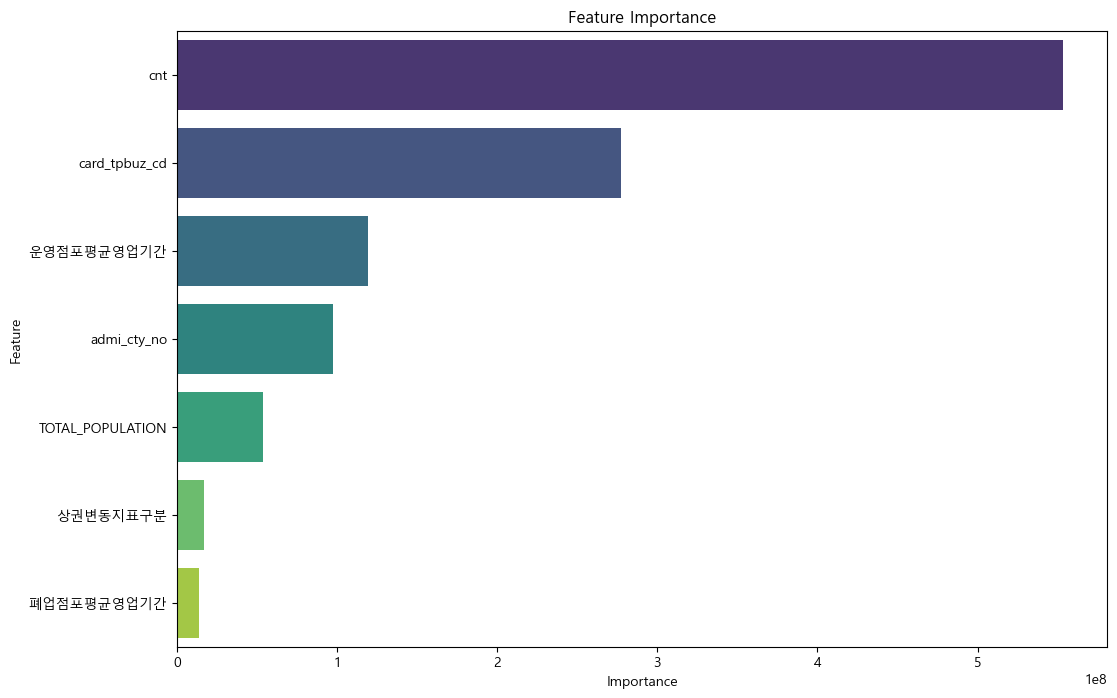

In [101]:

# feature importance 데이터프레임 생성
fi_df = fi.reset_index().rename(columns={'index': 'feature'})

# 중요도 순으로 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 학습 및 검증 데이터 저장

In [36]:
train_df.to_csv('train_df.csv', index=False, header=True, encoding='utf-8-sig')
test_df.to_csv('test_df.csv', index=False, header=True, encoding='utf-8-sig')
merged_df2.to_csv('preprocessed.csv', index=False, header=True, encoding='utf-8-sig')

## 서비스 적용 코드

In [100]:
# 예측할 데이터
data = {
    "admi_cty_no": [41590590],
    "card_tpbuz_cd": ["D01"],
    "amt": [365433405],  # 예측에서는 사용되지 않음
    "cnt": [906],
    "TOTAL_POPULATION": [7667999.44	],
    "운영점포평균영업기간": [37.7],
    "폐업점포평균영업기간": [33.8],
    "상권변동지표구분": ["LL"]
}

df_predict = pd.DataFrame(data)
df_predict = TabularDataset(df_predict)

In [101]:
predictor2 = TabularPredictor.load(r"AutogluonModels\ag-20240715_073451")
y_pred = predictor2.predict(df_predict.drop(columns=['amt']))

In [102]:
y_pred

0    339639264.0
Name: amt, dtype: float32